## GENERAL SETUP

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gallifrey.planets import PlanetModel
from gallifrey.utilities.dataframe import rename_labels
from gallifrey.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
)

## PLOT SETUP

In [4]:
set_plot_defaults()
figure_directory = "Original_NGPPS_sample"

## ORIGINAL SAMPLE (HOST STAR MASS = 1)

### Setup Variables and Planet Model

In [5]:
num_embryos = 50
host_star_mass = 1

planet_model = PlanetModel(num_embryos)

population_id = planet_model.get_population_id(num_embryos, host_star_mass)

categories = [
    category
    for category in planet_model.categories
    if category not in ["Dwarf", "D-Burner"]
]

### Recreate Original Sample (needs neighbors=1, to actually re-create original data)

In [6]:
original_variables = planet_model.get_systems(population_id).variables
original_sample = planet_model.prediction(
    categories,
    host_star_mass,
    variables=original_variables,
    return_full=True,
    neighbors=1,
)

# change labels for plotting
original_sample, labels = rename_labels(original_sample)

### Pair Plot (variations for one planet category with variables)

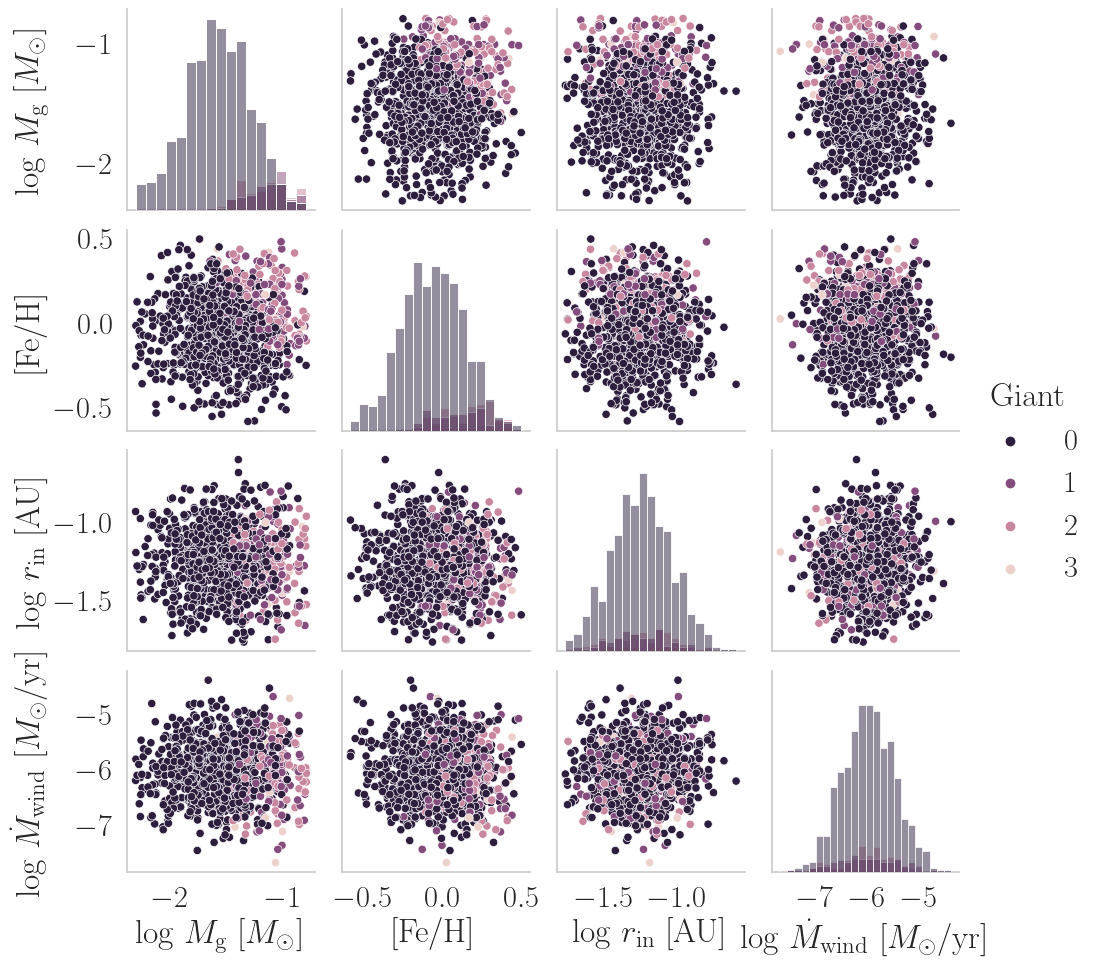

In [7]:
planet_type = "Giant"
pair_plot = sns.pairplot(
    original_sample.drop(columns=["age", *[c for c in categories if c != planet_type]]),
    hue=planet_type,
    diag_kind="hist",
    palette=get_palette(n_colors=4),
)
FigureProcessor(pair_plot.figure).save("pairplot.pdf", sub_directory=figure_directory)

### Correlation plot between Planet Types and Variables (Kendall Tau correlation coefficent)

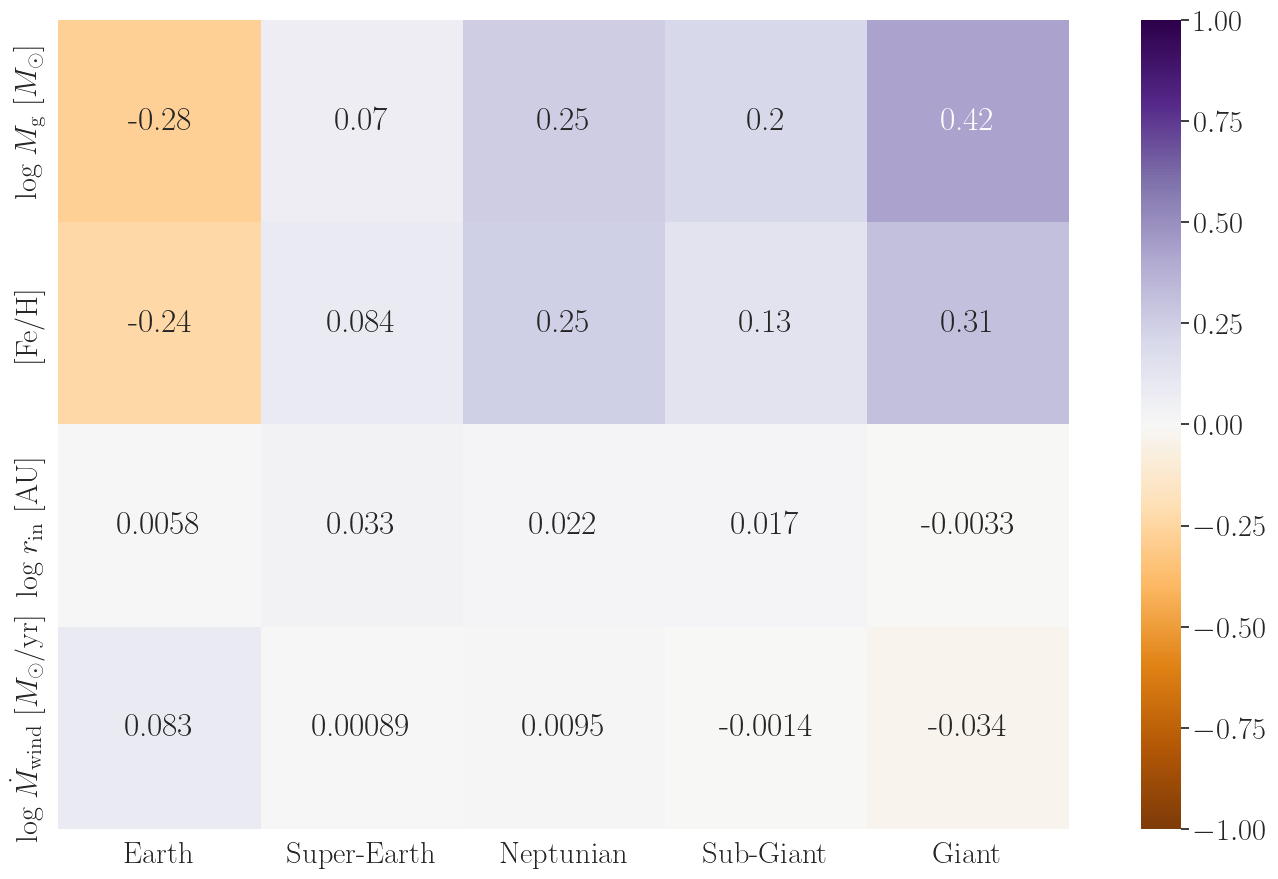

In [8]:
correlation_matrix = original_sample.corr(method="kendall").drop(
    columns=["age", *labels], index=["age", *categories]
)
correlation_plot = sns.heatmap(
    correlation_matrix,
    vmin=-1,
    vmax=1,
    square=True,
    annot=True,
    cmap="PuOr",
)
FigureProcessor(correlation_plot.figure).save(
    "correlation_matrix.pdf", sub_directory=figure_directory
)

### Changes of Number of Planets With Initial Embryo Count

In [9]:
num_embryo_list = [10, 20, 50, 100]

results_embryos = {}
for num in num_embryo_list:
    planet_model = PlanetModel(num)
    results_embryos[num] = planet_model.prediction(
        categories,
        host_star_mass,
        variables=original_variables,
        return_full=False,
        neighbors=1,
    ).sum()

results_embryos = pd.DataFrame(results_embryos).T
results_embryos = results_embryos.reset_index().rename(
    {"index": "Number of Embryos"}, axis="columns"
)

results_embryos_long_format = results_embryos.melt(
    id_vars="Number of Embryos",
    var_name="Category",
    value_name="Total Number",
)

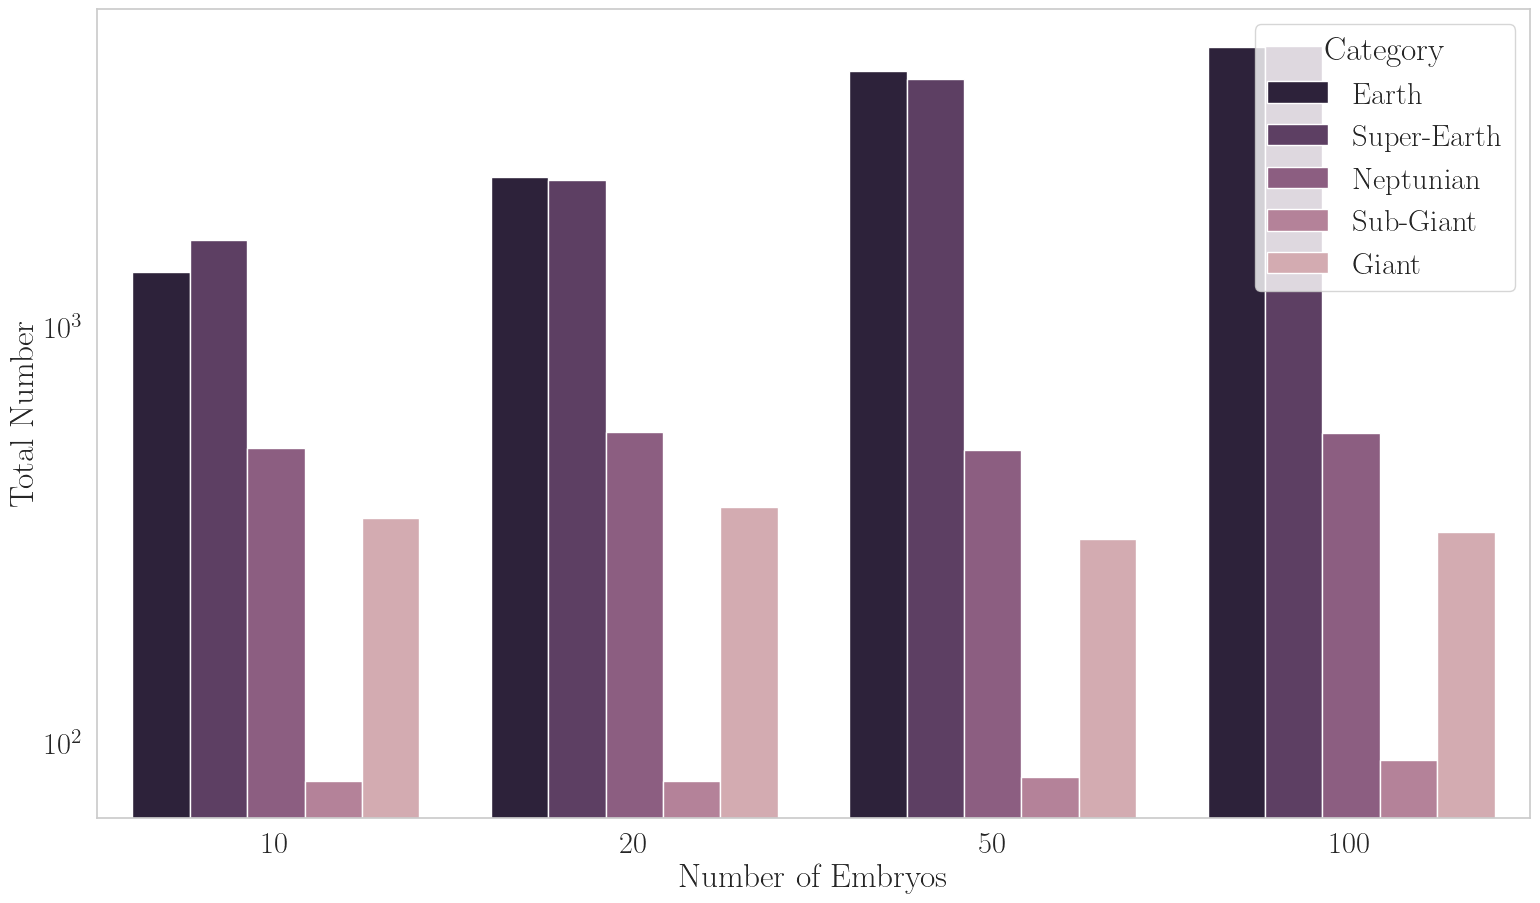

In [10]:
embryo_barplot = sns.barplot(
    data=results_embryos_long_format,
    x="Number of Embryos",
    y="Total Number",
    hue="Category",
    log=True,
    palette=get_palette(),
)
FigureProcessor(embryo_barplot.figure).save(
    "number_of_embryos.pdf", sub_directory=figure_directory
)

### Changes of Number of Planets With Host Star Mass

In [11]:
host_star_mass_list = [0.1, 0.3, 0.5, 0.7, 1]
planet_model = PlanetModel(num_embryos)

results_stellar_mass = {}
for mass in host_star_mass_list:
    results_stellar_mass[mass] = planet_model.prediction(
        categories,
        mass,
        variables=original_variables,
        return_full=False,
        neighbors=1,
    ).sum()

results_stellar_mass = pd.DataFrame(results_stellar_mass).T
results_stellar_mass = results_stellar_mass.reset_index().rename(
    {"index": r"Host Star Mass [$M_\odot$]"}, axis="columns"
)

results_stellar_mass_long_format = results_stellar_mass.melt(
    id_vars=r"Host Star Mass [$M_\odot$]",
    var_name="Category",
    value_name="Total Number",
)

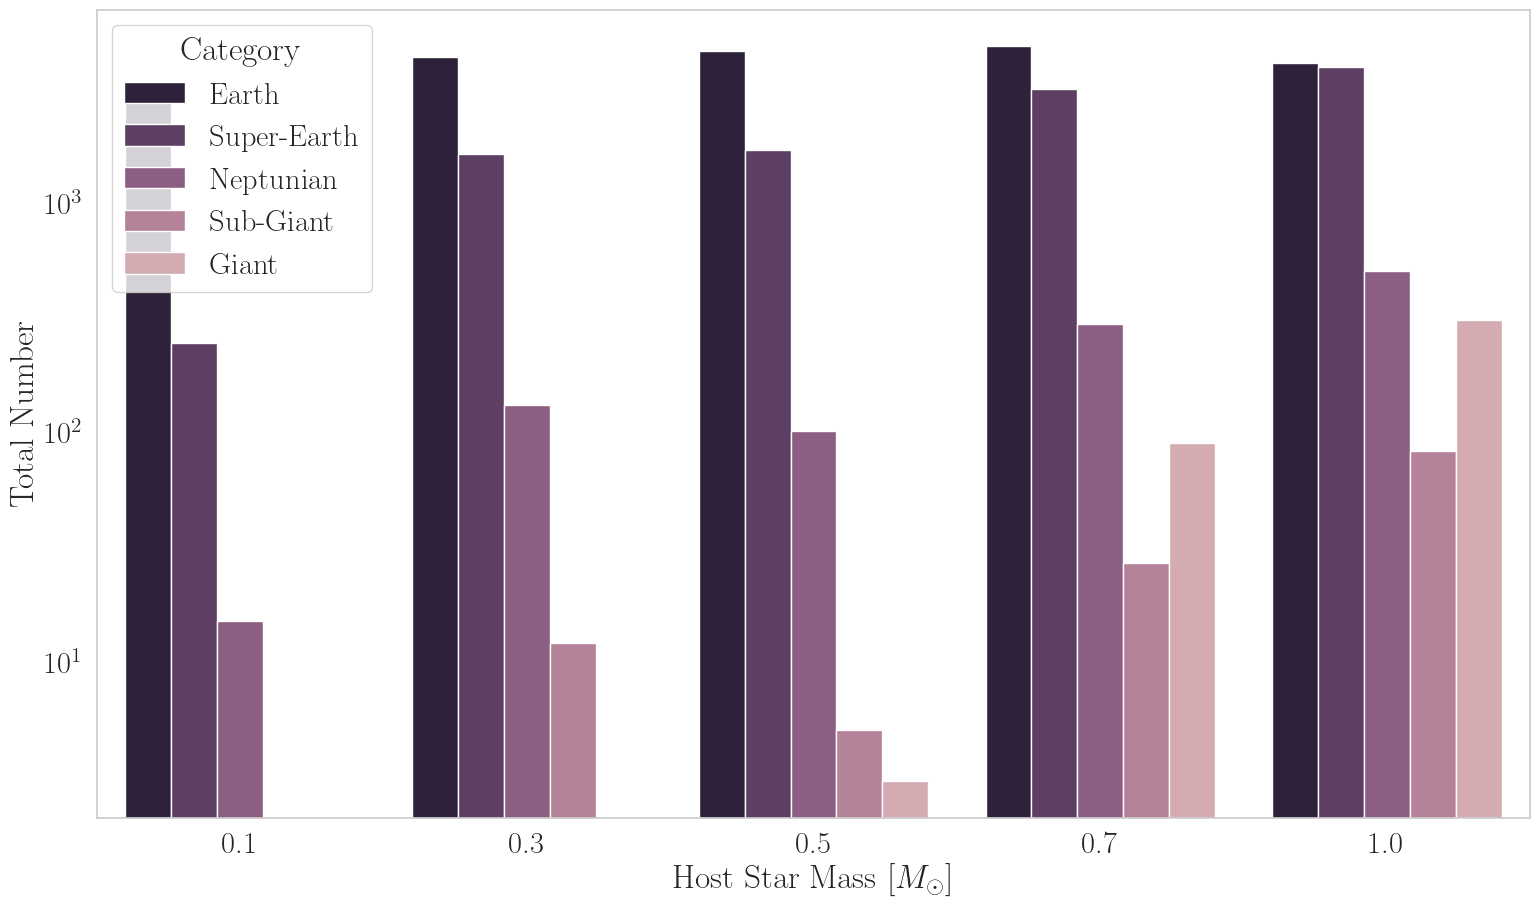

In [12]:
host_star_mass_plot = sns.barplot(
    data=results_stellar_mass_long_format,
    x=r"Host Star Mass [$M_\odot$]",
    y="Total Number",
    hue="Category",
    log=True,
    palette=get_palette(),
)
FigureProcessor(host_star_mass_plot.figure).save(
    "host_star_mass.pdf", sub_directory=figure_directory
)